# Supervised Bayesian model
With Halerium Causal Structures

## How to use the notebook

The following cells:
- specify objective, variables, and dependencies,
- set up the outlier detection models,
- read dataset,
- present results from the models.

To just see how it works for a toy example, simply run the whole notebook as is.

For your own project, adjust the details about objectives, variables, dataset etc. and then execute all cells in order.
The board "bayesian.board" will help you with detailed instructions.

# General Imports and Setup

In [1]:
import os
import shutil
from distutils.dir_util import copy_tree

import numpy as np
import pandas as pd
import halerium.core as hal
from halerium import CausalStructure

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from joblib import dump, load


By using this Application, You are agreeing to be bound by the terms and conditions of the Halerium End-User License Agreement that can be downloaded here: https://erium.de/halerium-eula.txt


# Project

In [2]:
experiment_name = {{cookiecutter.project_name}}  # please provide a name for the outlier detection experiment

# Dataset

In [3]:
time_series = False # Specify if the data is time series
path = '{{cookiecutter.data_path}}' # Specify the path of the data
test_size = 0.25

if path == 'default example':
    path = 'https://raw.githubusercontent.com/erium/halerium-example-data/main/outlier_detection/labeled_height_weight.csv'

if time_series:
    df = pd.read_csv(path, parse_dates=['date'], index_col = 'date')
else:
    df = pd.read_csv(path)

num_col = len(df.columns)

path = './../out'
isExist = os.path.exists(path)
if isExist:
  for root, dirs, files in os.walk(path):
      for f in files:
          os.unlink(os.path.join(root, f))
      for d in dirs:
          shutil.rmtree(os.path.join(root, d))
else:
  os.makedirs(path)

In [4]:
df

,Height,Weight,Age,Sex,Race,outlier
0,67.8,166,210,0,1,0
1,63.0,93,144,1,0,0
2,50.1,54,119,0,0,0
3,55.7,69,130,1,0,0
4,63.2,115,157,0,0,0
...,...,...,...,...,...,...
193,62.8,94,183,0,0,0
194,64.5,130,189,1,1,0
195,66.1,135,189,1,0,0
196,66.1,119,174,1,0,0


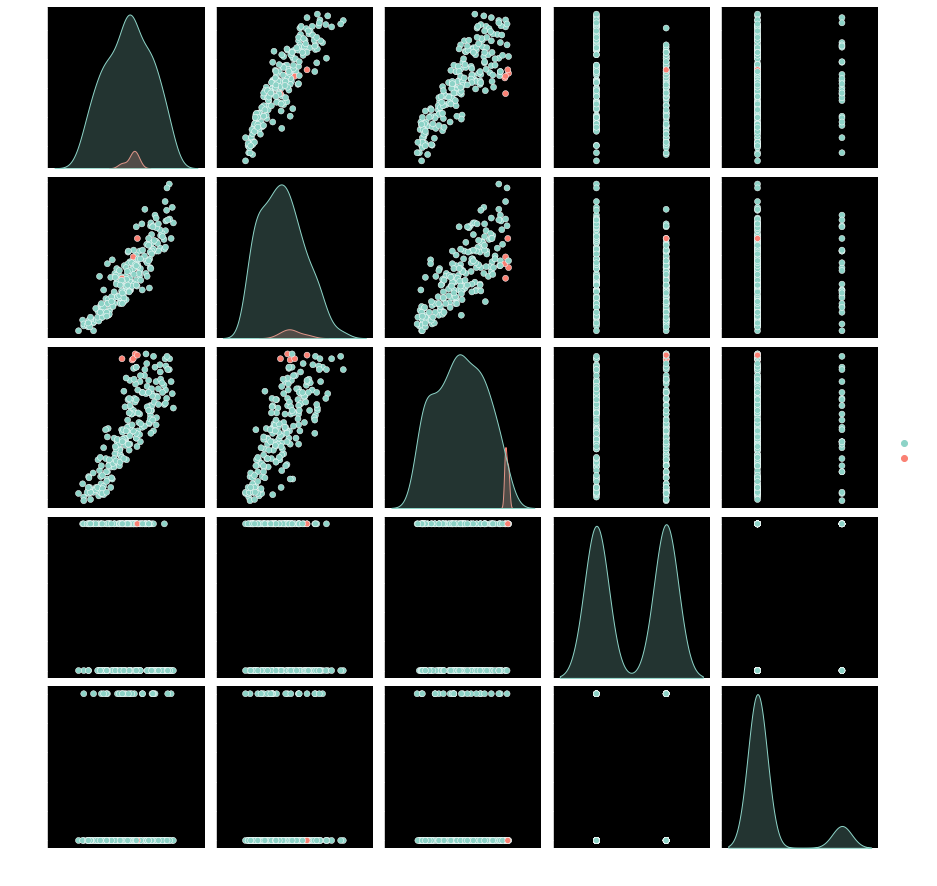

In [5]:
pairplot_hue = 'outlier'
palette ={0: "C0", 1: "C3"}
sns.pairplot(df, hue = pairplot_hue, palette=palette)

## Split the Data

In [6]:
df_train, df_test = train_test_split(df, test_size = test_size)

## Model the Causal structure

In [7]:
data = pd.DataFrame(data={"(age)": df_train["Age"],
                          "(height|age)": df_train["Height"],
                          "(outlier|age,height)": df_train["outlier"]})

test_data = pd.DataFrame(data={"(age)": df_test["Age"],
                          "(height|age)": df_test["Height"]})

In [8]:
data

,(age),(height|age),"(outlier|age,height)"
5,102,48.8,0
125,141,58.4,0
85,154,63.7,0
73,217,70.5,0
43,183,60.6,0
...,...,...,...
97,150,57.8,0
89,158,54.6,0
54,171,63.7,0
71,146,60.6,0


In [9]:
dependencies = [
    ["(age)", "(height|age)"], # the column '(height|age)' depends on '(age)'
    [["(age)", "(height|age)"], "(outlier|age,height)"], # the column '(outlier|age,height)' depends on '(age)' and '(height|age)'
]

In [10]:
outlier_threshold = 0.5
causal_structure = CausalStructure(dependencies)
causal_structure.train(data)
prediction = causal_structure.predict(data=test_data)
prediction_mean, prediction_std = causal_structure.predict(
    data=test_data, return_std=True)

## Outlier Prediction

In [11]:
prediction.loc[prediction['(outlier|age,height)'] < outlier_threshold, '(outlier|age,height)'] = 0
prediction.loc[prediction['(outlier|age,height)'] >= outlier_threshold, '(outlier|age,height)'] = 1
prediction

,(age),(height|age),"(outlier|age,height)"
91,110.0,56.0,0.0
61,129.0,55.6,0.0
136,123.0,54.8,0.0
166,152.0,55.1,0.0
192,208.0,71.2,0.0
174,157.0,60.1,0.0
46,221.0,62.5,0.0
151,142.0,57.4,0.0
106,117.0,56.4,0.0
109,164.0,63.5,0.0


In [12]:
y_test = df_test['outlier']
y_pred = prediction['(outlier|age,height)']
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred, target_names=['Non-outlier', 'Outlier'])

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(pd.Series([tn, fp, fn, tp], index = ['True Negatives (Non-outliers)', 'False Positives (Non-outliers predicted as outliers)', 'False Negatives (Outliers predicted as non-outliers', 'True Positives (Outliers)']))
print(report)

True Negatives (Non-outliers)                           48
False Positives (Non-outliers predicted as outliers)     0
False Negatives (Outliers predicted as non-outliers      2
True Positives (Outliers)                                0
dtype: int64
              precision    recall  f1-score   support

 Non-outlier       0.96      1.00      0.98        48
     Outlier       0.00      0.00      0.00         2

    accuracy                           0.96        50
   macro avg       0.48      0.50      0.49        50
weighted avg       0.92      0.96      0.94        50



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classificat

In [13]:
# Export the causal structure
dump([data, dependencies, df, time_series, outlier_threshold], './../out/supervised_bayesian.joblib')

['./../out/supervised_bayesian.joblib']